<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-16" data-toc-modified-id="Chapter-16-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter 16</a></span><ul class="toc-item"><li><span><a href="#16.1.-Geometric-people" data-toc-modified-id="16.1.-Geometric-people-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>16.1. Geometric people</a></span></li><li><span><a href="#16.2.-Hidden-minds-and-observed-behavior" data-toc-modified-id="16.2.-Hidden-minds-and-observed-behavior-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>16.2. Hidden minds and observed behavior</a></span></li></ul></li></ul></div>

In [2]:
library(tidyverse)

# loads experimental branch of statistical rethinking pkg
library(rethinking)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=native')
although this causes Stan to throw an error on a few processors.


Attaching package: 'rstan'


The following object is masked from 'package:tidyr':

    extract


Loading r

# Chapter 16

## 16.1. Geometric people

In [4]:
data(Howell1)
d <- Howell1 

In [5]:
d %>% head()

height,weight,age,male
<dbl>,<dbl>,<dbl>,<int>
151.765,47.82561,63,1
139.700,36.48581,63,0
136.525,31.86484,65,0
156.845,53.04191,41,1
145.415,41.27687,51,0
163.830,62.99259,35,1


In [6]:
# scale observed variables
d$w <- d$weight / mean(d$weight)
d$h <- d$height / mean(d$height)

In [7]:
## R code 16.2
m16.1 <- ulam(
    alist(
        w ~ dlnorm( mu , sigma ),
        exp(mu) <- 3.141593 * k * p^2 * h^3,
        p ~ beta( 2 , 18 ),
        k ~ exponential( 0.5 ),
        sigma ~ exponential( 1 )
    ), data=d , chains=4 , cores=4 )

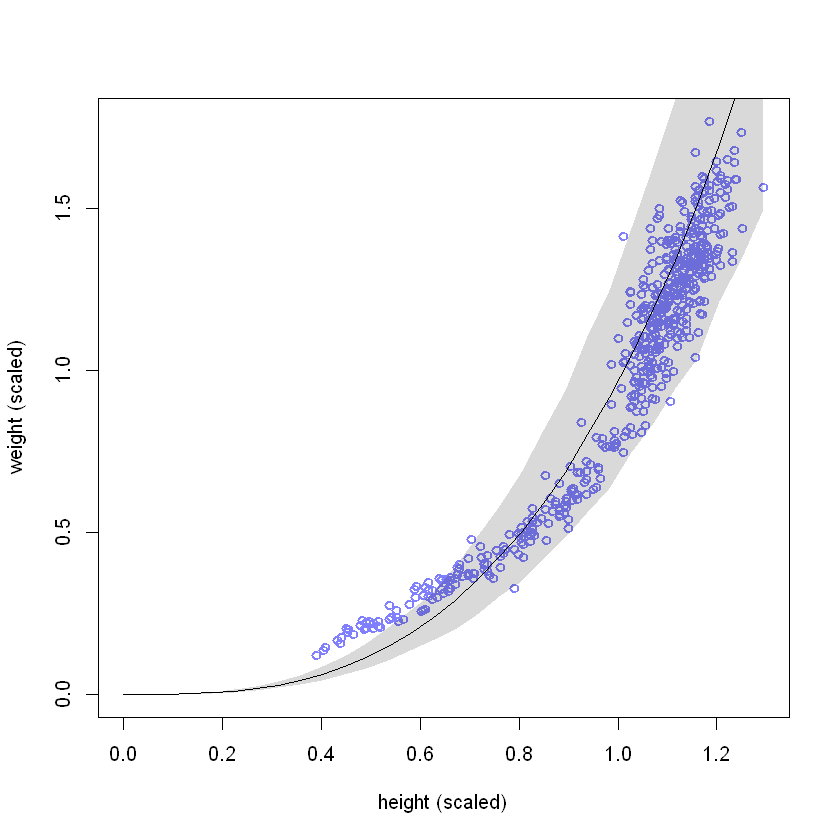

In [8]:
## R code 16.3
h_seq <- seq( from=0 , to=max(d$h) , length.out=30 )
w_sim <- sim( m16.1 , data=list(h=h_seq) )
mu_mean <- apply( w_sim , 2 , mean )
w_CI <- apply( w_sim , 2 , PI )
plot( d$h , d$w , xlim=c(0,max(d$h)) , ylim=c(0,max(d$w)) , col=rangi2 ,
    lwd=2 , xlab="height (scaled)" , ylab="weight (scaled)" )
lines( h_seq , mu_mean )
shade( w_CI , h_seq )

## 16.2. Hidden minds and observed behavior

In [3]:
data(Boxes)
precis(Boxes)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
y,2.1208267,0.7279860,1,3,<U+2583><U+2581><U+2581><U+2581><U+2587><U+2581><U+2581><U+2581><U+2581><U+2585>
gender,1.5055644,0.5003669,1,2,<U+2587><U+2581><U+2581><U+2581><U+2581><U+2581><U+2581><U+2581><U+2581><U+2587>
age,8.0302067,2.4979055,5,13,<U+2587><U+2583><U+2585><U+2583><U+2583><U+2583><U+2582><U+2582><U+2582><U+2581>
majority_first,0.4848967,0.5001696,0,1,<U+2587><U+2581><U+2581><U+2581><U+2581><U+2581><U+2581><U+2581><U+2581><U+2587>
culture,3.7519873,1.9603189,1,8,<U+2583><U+2582><U+2581><U+2587><U+2581><U+2582><U+2581><U+2582><U+2581><U+2582><U+2581><U+2581><U+2581><U+2581>


In [4]:
table( Boxes$y ) / length( Boxes$y )


        1         2         3 
0.2114467 0.4562798 0.3322734 

In [5]:
table( Boxes$y )


  1   2   3 
133 287 209 

In [7]:
length( Boxes$y )

[1] 629

In [10]:
set.seed(7)
N <- 30 # number of children

# half are random
# sample from 1,2,3 at random for each
y1 <- sample( 1:3 , size=N/2 , replace=TRUE )

# half follow majority
y2 <- rep( 2 , N/2 )

# combine and shuffle y1 and y2
y <- sample( c(y1,y2) )

# count the 2s
sum(y==2)/N

[1] 0.7333333

About two-thirds of the choices are for the majority color, but only half the children are
actually following the majority. The above is only one simulation, but it demonstrates the
problem. When different hidden strategies can produce the same behavior, inference about
strategy is more complicated than just counting behavior.

Now we need a statistical model that reflects the generative model above. <font color = 'blue'>Remember, statistical models run in reverse of generative models. 
    
* In the generative model, we assume strategies and simulate observed behavior. 
    
* In the statistical model, we instead assume observed behavior (the data) and simulate strategies (parameters)</font>. 

In this example, we can’t directly measure each child’s strategy. It is an unobserved variable. 

* But each strategy has a specific probability of producing each choice. We can use that fact to compute the probability of each choice, given parameters which specify the probability of each strategy. 

* Then we let Bayes loose and get the posterior distribution of each strategy back. 

<b><font color = 'purple'>Before we can let Bayes loose, we’ll need to enumerate the parameters, assign priors to each, and also figure out some technical issues for coding. </font></b> I’ll move through these tasks slowly. 

<font color = 'blue'>The unobserved variables are the probabilities that a child uses each of the five strategies.</font> This means five values, but since these must sum to one, we need only four parameters. There is a variable type called a <span style='background-color: lightgreen'>simplex</span> that handles this for us. <font color = 'green'>A simplex is a vector of values that must sum to some constant, usually one.</font> 

> <font color = 'green'>Stan allows us to declare a vector of parameters as a simplex, and then Stan handles the bookkeeping of the constant sum for us</font>. We can give this simplex a Dirichlet prior, which is a prior for probability distributions. 

We used both Dirichlet and a simplex already back in Chapter 12 to construct ordered categorical predictors (page 405). We’ll use a weak uniform prior on the simplex of strategy probabilities, which we’ll label p: 

$p ∼ Dirichlet([4, 4, 4, 4, 4])$

As you saw back in Chapter 12, this prior doesn’t mean that we expect the strategies to be equally probable. Instead it <font color = 'blue'>means that we expect that any one of them could be more or less probable than any other</font>. If you make those 4s larger, the prior starts to say that we expect them to be actually equal.